=== MIDI Harmony Generation System ===
Using device: cpu

1. Loading and analyzing data...
Loading MIDI data...
Found 1034 total melody files
Filtering for jig files: 340 files starting with 'jigs'


Loading jig files:  71%|███████   | 240/340 [00:01<00:00, 189.95it/s]

✗ Skipped jigs336.mid: no corresponding chord file


Loading jig files: 100%|██████████| 340/340 [00:01<00:00, 181.34it/s]

✗ Skipped jigs6.mid: no corresponding chord file
Successfully loaded 338 jig melody-harmony pairs
Training samples: 270
Validation samples: 68
=== Dataset Analysis ===
Total melody-harmony pairs: 338
Vocabulary size: 92
Pitch range: 21 - 108


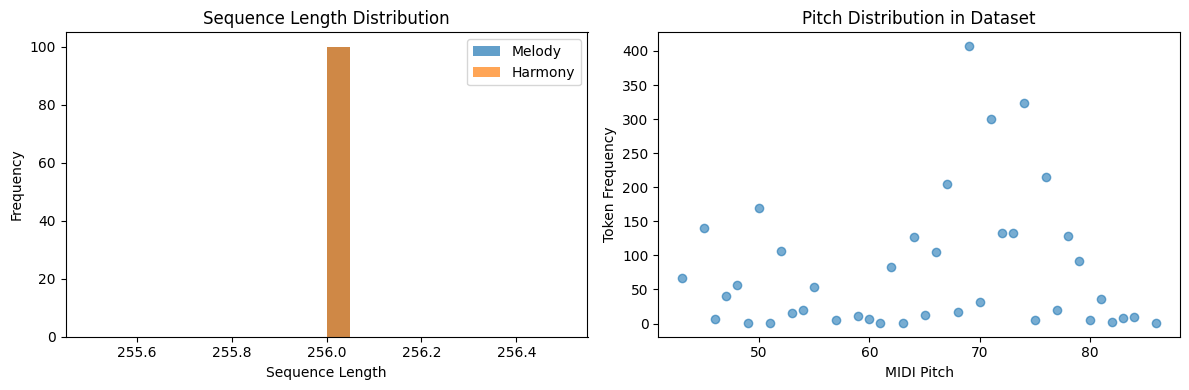


2. Training the model...
Model created with 961,628 parameters
Starting training...


Epoch 1/15: 100%|██████████| 34/34 [00:07<00:00,  4.29it/s]


Epoch 1: Train Loss = 1.0977, Val Loss = 0.4117


Epoch 2/15: 100%|██████████| 34/34 [00:07<00:00,  4.32it/s]


Epoch 2: Train Loss = 0.4029, Val Loss = 0.3767


Epoch 3/15: 100%|██████████| 34/34 [00:08<00:00,  4.03it/s]


Epoch 3: Train Loss = 0.3769, Val Loss = 0.3598


Epoch 4/15: 100%|██████████| 34/34 [00:08<00:00,  3.88it/s]


Epoch 4: Train Loss = 0.3627, Val Loss = 0.3516


Epoch 5/15: 100%|██████████| 34/34 [00:08<00:00,  3.87it/s]


Epoch 5: Train Loss = 0.3533, Val Loss = 0.3428


Epoch 6/15: 100%|██████████| 34/34 [00:08<00:00,  3.98it/s]


Epoch 6: Train Loss = 0.3429, Val Loss = 0.3295


Epoch 7/15: 100%|██████████| 34/34 [00:08<00:00,  4.08it/s]


Epoch 7: Train Loss = 0.3246, Val Loss = 0.3039


Epoch 8/15: 100%|██████████| 34/34 [00:08<00:00,  4.01it/s]


Epoch 8: Train Loss = 0.2964, Val Loss = 0.2671


Epoch 9/15: 100%|██████████| 34/34 [00:08<00:00,  3.79it/s]


Epoch 9: Train Loss = 0.2541, Val Loss = 0.2144


Epoch 10/15: 100%|██████████| 34/34 [00:08<00:00,  3.92it/s]


Epoch 10: Train Loss = 0.2115, Val Loss = 0.1804


Epoch 11/15: 100%|██████████| 34/34 [00:08<00:00,  4.16it/s]


Epoch 11: Train Loss = 0.1874, Val Loss = 0.1695


Epoch 12/15: 100%|██████████| 34/34 [00:07<00:00,  4.42it/s]


Epoch 12: Train Loss = 0.1709, Val Loss = 0.1550


Epoch 13/15: 100%|██████████| 34/34 [00:06<00:00,  4.91it/s]


Epoch 13: Train Loss = 0.1572, Val Loss = 0.1457


Epoch 14/15: 100%|██████████| 34/34 [00:08<00:00,  4.10it/s]


Epoch 14: Train Loss = 0.1462, Val Loss = 0.1373


Epoch 15/15: 100%|██████████| 34/34 [00:08<00:00,  4.12it/s]


Epoch 15: Train Loss = 0.1384, Val Loss = 0.1344


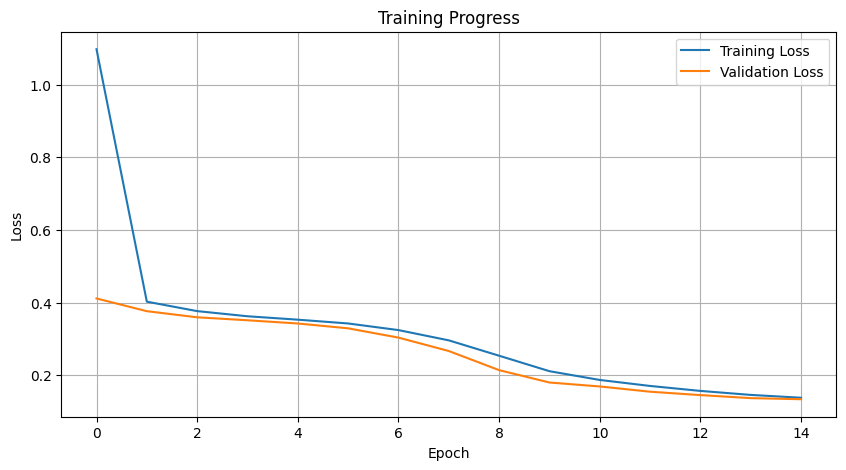

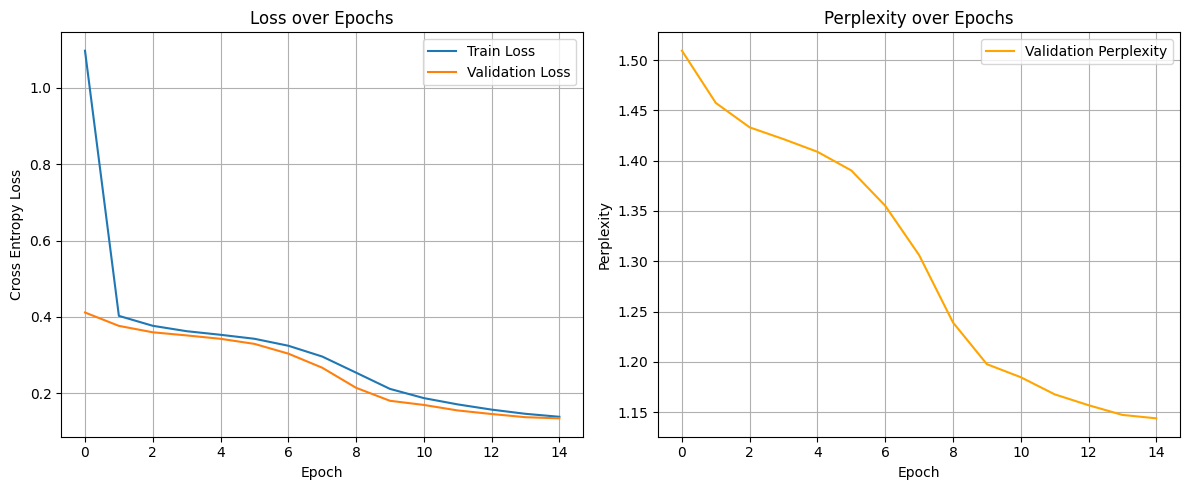


3. Saving the model...
Model saved to: harmony_generator_model.pth

4. Generating harmony...
Generated combined melody+harmony saved to: generated_harmony_jigs85_combined.mid
Generated harmony-only saved to: generated_harmony_jigs85_harmony_only.mid

Generated harmony for jig: jigs85.mid
Combined output: generated_harmony_jigs85_combined.mid
Harmony only: generated_harmony_jigs85_harmony_only.mid
Generated combined melody+harmony saved to: generated_harmony_jigs91_combined.mid
Generated harmony-only saved to: generated_harmony_jigs91_harmony_only.mid
Generated for jigs91.mid:
  Combined: generated_harmony_jigs91_combined.mid
  Harmony: generated_harmony_jigs91_harmony_only.mid
Generated combined melody+harmony saved to: generated_harmony_jigs46_combined.mid
Generated harmony-only saved to: generated_harmony_jigs46_harmony_only.mid
Generated for jigs46.mid:
  Combined: generated_harmony_jigs46_combined.mid
  Harmony: generated_harmony_jigs46_harmony_only.mid
Generated combined melody+h

In [8]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pretty_midi
from collections import Counter
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

class MIDITokenizer:
    """Tokenizer for MIDI data that converts notes to tokens and vice versa"""
    
    def __init__(self, min_pitch=21, max_pitch=108, time_resolution=16):
        self.min_pitch = min_pitch
        self.max_pitch = max_pitch
        self.time_resolution = time_resolution
        
        # Special tokens
        self.pad_token = 0
        self.start_token = 1
        self.end_token = 2
        self.rest_token = 3
        
        # Note tokens start after special tokens
        self.note_offset = 4
        self.vocab_size = self.note_offset + (max_pitch - min_pitch + 1)
        
        # Create mappings
        self.token_to_pitch = {}
        self.pitch_to_token = {}
        
        for pitch in range(min_pitch, max_pitch + 1):
            token = pitch - min_pitch + self.note_offset
            self.token_to_pitch[token] = pitch
            self.pitch_to_token[pitch] = token
    
    def midi_to_tokens(self, midi_file_path, max_length=256):
        """Convert MIDI file to sequence of tokens"""
        try:
            midi = pretty_midi.PrettyMIDI(midi_file_path)
            
            # Get the first instrument (melody or harmony)
            if len(midi.instruments) == 0:
                return [self.start_token, self.end_token]
            
            instrument = midi.instruments[0]
            
            # Convert notes to grid representation
            end_time = midi.get_end_time()
            time_steps = int(end_time * self.time_resolution) + 1
            
            # Create a grid where each time step can have a note
            grid = [self.rest_token] * min(time_steps, max_length - 2)
            
            for note in instrument.notes:
                start_step = int(note.start * self.time_resolution)
                if start_step < len(grid) and self.min_pitch <= note.pitch <= self.max_pitch:
                    grid[start_step] = self.pitch_to_token[note.pitch]
            
            # Add start and end tokens
            tokens = [self.start_token] + grid + [self.end_token]
            
            # Truncate if too long
            if len(tokens) > max_length:
                tokens = tokens[:max_length-1] + [self.end_token]
                
            return tokens
            
        except Exception as e:
            print(f"Error processing {midi_file_path}: {e}")
            return [self.start_token, self.end_token]
    
    def tokens_to_midi(self, tokens, output_path, tempo=120, program=0, name="Generated"):
        """Convert sequence of tokens back to MIDI file"""
        midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
        instrument = pretty_midi.Instrument(program=program, name=name)
        
        current_time = 0
        time_step = 1.0 / self.time_resolution
        
        for token in tokens:
            if token in [self.start_token, self.end_token, self.pad_token]:
                continue
            elif token == self.rest_token:
                current_time += time_step
            elif token in self.token_to_pitch:
                pitch = self.token_to_pitch[token]
                note = pretty_midi.Note(
                    velocity=80,
                    pitch=pitch,
                    start=current_time,
                    end=current_time + time_step
                )
                instrument.notes.append(note)
                current_time += time_step
            else:
                current_time += time_step
        
        midi.instruments.append(instrument)
        midi.write(output_path)
        return output_path
    
    def create_combined_midi(self, melody_tokens, harmony_tokens, output_path, tempo=120):
        """Create MIDI file with both melody and harmony tracks"""
        midi = pretty_midi.PrettyMIDI(initial_tempo=tempo)
        
        # Create melody instrument (e.g., flute/recorder for Irish traditional)
        melody_instrument = pretty_midi.Instrument(program=0, name="Melody (Flute)")  # Flute
        
        # Create harmony instrument (e.g., guitar for chords)
        harmony_instrument = pretty_midi.Instrument(program=0, name="Harmony (Guitar)")  # Acoustic Guitar
        
        time_step = 1.0 / self.time_resolution
        
        # Process melody
        current_time = 0
        for token in melody_tokens:
            if token in [self.start_token, self.end_token, self.pad_token]:
                continue
            elif token == self.rest_token:
                current_time += time_step
            elif token in self.token_to_pitch:
                pitch = self.token_to_pitch[token]
                note = pretty_midi.Note(
                    velocity=90,  # Slightly louder for melody
                    pitch=pitch,
                    start=current_time,
                    end=current_time + time_step
                )
                melody_instrument.notes.append(note)
                current_time += time_step
            else:
                current_time += time_step
        
        # Process harmony with sustained notes
        current_time = 0
        last_pitch = None
        note_start = None

        for token in harmony_tokens + [self.end_token]:  # Add end token to finalize last note
            if token in [self.start_token, self.pad_token]:
                continue
            elif token == self.rest_token:
                current_time += time_step
            elif token == self.end_token:
                # If there's a held note, end it now
                if last_pitch is not None:
                    note = pretty_midi.Note(
                        velocity=70,
                        pitch=last_pitch,
                        start=note_start,
                        end=current_time
                    )
                    harmony_instrument.notes.append(note)
                    last_pitch = None
            elif token in self.token_to_pitch:
                pitch = self.token_to_pitch[token]
                if pitch != last_pitch:
                    # If there's an active note, end it now
                    if last_pitch is not None:
                        note = pretty_midi.Note(
                            velocity=70,
                            pitch=last_pitch,
                            start=note_start,
                            end=current_time
                        )
                        harmony_instrument.notes.append(note)
                    # Start new note
                    last_pitch = pitch
                    note_start = current_time
                current_time += time_step
            else:
                current_time += time_step
        
        # Add both instruments to MIDI
        midi.instruments.append(melody_instrument)
        midi.instruments.append(harmony_instrument)
        
        midi.write(output_path)
        return output_path

class MelodyHarmonyDataset(Dataset):
    """Dataset for melody-harmony pairs"""
    
    def __init__(self, midi_folder, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.data = []
        
        self.load_data(midi_folder)
    
    def load_data(self, midi_folder):
        """Load melody-harmony pairs from folder structure"""
        print("Loading MIDI data...")
        
        # Scan for available MIDI files
        melody_folder = os.path.join(midi_folder, "melody")
        chords_folder = os.path.join(midi_folder, "chords")
        
        if not os.path.exists(melody_folder) or not os.path.exists(chords_folder):
            print(f"Expected folder structure: {midi_folder}/melody/ and {midi_folder}/chords/")
            return
        
        # Filter for only jig MIDI files
        all_melody_files = os.listdir(melody_folder)
        jig_melody_files = [f for f in all_melody_files if f.startswith('jigs') and f.endswith('.mid')]
        
        print(f"Found {len(all_melody_files)} total melody files")
        print(f"Filtering for jig files: {len(jig_melody_files)} files starting with 'jigs'")
        
        if len(jig_melody_files) == 0:
            print("Warning: No files starting with 'jigs' found in melody folder")
            print("Available files:", all_melody_files[:10], "..." if len(all_melody_files) > 10 else "")
        
        for melody_file in tqdm(jig_melody_files, desc="Loading jig files"):
            melody_path = os.path.join(melody_folder, melody_file)
            chord_path = os.path.join(chords_folder, melody_file)
            
            if os.path.exists(chord_path):
                melody_tokens = self.tokenizer.midi_to_tokens(melody_path, self.max_length)
                harmony_tokens = self.tokenizer.midi_to_tokens(chord_path, self.max_length)
                
                # Ensure both sequences are valid
                if len(melody_tokens) > 2 and len(harmony_tokens) > 2:
                    self.data.append((melody_tokens, harmony_tokens))
                else:
                    print(f"✗ Skipped {melody_file}: insufficient data")
            else:
                print(f"✗ Skipped {melody_file}: no corresponding chord file")
        
        print(f"Successfully loaded {len(self.data)} jig melody-harmony pairs")
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        melody_tokens, harmony_tokens = self.data[idx]
        
        # Pad sequences to max_length
        melody_padded = melody_tokens + [self.tokenizer.pad_token] * (self.max_length - len(melody_tokens))
        harmony_padded = harmony_tokens + [self.tokenizer.pad_token] * (self.max_length - len(harmony_tokens))
        
        return {
            'melody': torch.tensor(melody_padded[:self.max_length], dtype=torch.long),
            'harmony': torch.tensor(harmony_padded[:self.max_length], dtype=torch.long)
        }

class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""
    
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class MelodyToHarmonyTransformer(nn.Module):
    """Transformer model for melody to harmony generation"""
    
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=2, max_seq_length=256):
        super().__init__()
        
        self.d_model = d_model
        self.vocab_size = vocab_size
        
        # Embeddings
        self.melody_embedding = nn.Embedding(vocab_size, d_model)
        self.harmony_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_seq_length)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dim_feedforward=d_model * 4,
            dropout=0.1,
            batch_first=True
        )
        
        # Output projection
        self.output_projection = nn.Linear(d_model, vocab_size)
        
        # Initialize weights
        self.init_weights()
    
    def init_weights(self):
        initrange = 0.1
        self.melody_embedding.weight.data.uniform_(-initrange, initrange)
        self.harmony_embedding.weight.data.uniform_(-initrange, initrange)
        self.output_projection.bias.data.zero_()
        self.output_projection.weight.data.uniform_(-initrange, initrange)
    
    def forward(self, melody, harmony_input, melody_mask=None, harmony_mask=None):
        # Embeddings
        melody_emb = self.melody_embedding(melody) * np.sqrt(self.d_model)
        harmony_emb = self.harmony_embedding(harmony_input) * np.sqrt(self.d_model)
        
        # Positional encoding
        melody_emb = self.pos_encoding(melody_emb.transpose(0, 1)).transpose(0, 1)
        harmony_emb = self.pos_encoding(harmony_emb.transpose(0, 1)).transpose(0, 1)
        
        # Generate causal mask for decoder
        seq_len = harmony_input.size(1)
        causal_mask = torch.triu(torch.ones(seq_len, seq_len) * float('-inf'), diagonal=1)
        causal_mask = causal_mask.to(melody.device)
        
        # Transformer forward pass
        output = self.transformer(
            src=melody_emb,
            tgt=harmony_emb,
            tgt_mask=causal_mask,
            src_key_padding_mask=melody_mask,
            tgt_key_padding_mask=harmony_mask
        )
        
        # Project to vocabulary
        logits = self.output_projection(output)
        
        return logits
    
    def generate(self, melody, tokenizer, max_length=256, temperature=1.0, stop_on_end_token=False):
        """Generate harmony given a melody"""
        self.eval()
        device = next(self.parameters()).device

        with torch.no_grad():
            melody = melody.to(device)
            batch_size = melody.size(0)
            
            harmony = torch.full((batch_size, 1), tokenizer.start_token, dtype=torch.long, device=device)
            for _ in range(max_length - 1):
                logits = self.forward(melody, harmony)
                next_token_logits = logits[:, -1, :] / temperature
                probs = torch.softmax(next_token_logits, dim=-1)
                next_token = torch.multinomial(probs, 1)
                harmony = torch.cat([harmony, next_token], dim=1)

                if stop_on_end_token and (next_token == tokenizer.end_token).all():
                    break
            
            return harmony



class HarmonyGenerator:
    """Main class for training and generating harmonies"""
    
    def __init__(self, midi_folder):
        self.midi_folder = midi_folder
        self.tokenizer = MIDITokenizer()
        self.model = None
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}")
        
    def load_data(self):
        """Load and prepare the dataset"""
        self.dataset = MelodyHarmonyDataset(self.midi_folder, self.tokenizer)
        
        if len(self.dataset) == 0:
            raise ValueError("No data found. Please check your MIDI folder structure.")
        
        # Split data
        train_size = int(0.8 * len(self.dataset))
        val_size = len(self.dataset) - train_size
        
        self.train_dataset, self.val_dataset = torch.utils.data.random_split(
            self.dataset, [train_size, val_size]
        )
        
        # Create data loaders
        self.train_loader = DataLoader(self.train_dataset, batch_size=8, shuffle=True)
        self.val_loader = DataLoader(self.val_dataset, batch_size=8, shuffle=False)
        
        print(f"Training samples: {len(self.train_dataset)}")
        print(f"Validation samples: {len(self.val_dataset)}")
    
    def create_model(self):
        """Create the transformer model"""
        self.model = MelodyToHarmonyTransformer(
            vocab_size=self.tokenizer.vocab_size,
            d_model=128,
            nhead=4,
            num_layers=2,  # Reduced for faster training
            max_seq_length=256
        ).to(self.device)
        
        print(f"Model created with {sum(p.numel() for p in self.model.parameters()):,} parameters")
    
    def train(self, num_epochs=20, learning_rate=1e-4):
        """Train the model"""
        if self.model is None:
            self.create_model()
        
        criterion = nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token)
        optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
        
        train_losses = []
        val_losses = []
        val_perplexities = []
        
        print("Starting training...")
        
        for epoch in range(num_epochs):
            # Training
            self.model.train()
            train_loss = 0
            train_steps = 0
            
            for batch in tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
                melody = batch['melody'].to(self.device)
                harmony = batch['harmony'].to(self.device)
                
                # Create input and target for harmony
                harmony_input = harmony[:, :-1]
                harmony_target = harmony[:, 1:]
                
                # Create padding masks
                melody_mask = (melody == self.tokenizer.pad_token)
                harmony_mask = (harmony_input == self.tokenizer.pad_token)
                
                optimizer.zero_grad()
                
                # Forward pass
                logits = self.model(melody, harmony_input, melody_mask, harmony_mask)
                
                # Calculate loss
                loss = criterion(logits.reshape(-1, self.tokenizer.vocab_size), harmony_target.reshape(-1))
                
                # Backward pass
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                
                train_loss += loss.item()
                train_steps += 1
            
            avg_train_loss = train_loss / train_steps
            train_losses.append(avg_train_loss)
            
            # Validation
            self.model.eval()
            val_loss = 0
            val_steps = 0
            
            with torch.no_grad():
                for batch in self.val_loader:
                    melody = batch['melody'].to(self.device)
                    harmony = batch['harmony'].to(self.device)
                    
                    harmony_input = harmony[:, :-1]
                    harmony_target = harmony[:, 1:]
                    
                    melody_mask = (melody == self.tokenizer.pad_token)
                    harmony_mask = (harmony_input == self.tokenizer.pad_token)
                    
                    logits = self.model(melody, harmony_input, melody_mask, harmony_mask)
                    loss = criterion(logits.reshape(-1, self.tokenizer.vocab_size), harmony_target.reshape(-1))
                    
                    val_loss += loss.item()
                    val_steps += 1
                    
            
            # After validation loop
            avg_val_loss = val_loss / val_steps if val_steps > 0 else 0
            perplexity = np.exp(avg_val_loss) if avg_val_loss < 50 else float('inf')  # avoid overflow
            val_losses.append(avg_val_loss)
            val_perplexities.append(perplexity)

            
            scheduler.step(avg_val_loss)
            
            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")
        
        # Plot training curves
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()
        # Plot training curves
        plt.figure(figsize=(12, 5))

        # Plot Loss
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Cross Entropy Loss')
        plt.title('Loss over Epochs')
        plt.legend()
        plt.grid(True)

        # Plot Perplexity
        plt.subplot(1, 2, 2)
        plt.plot(val_perplexities, label='Validation Perplexity', color='orange')
        plt.xlabel('Epoch')
        plt.ylabel('Perplexity')
        plt.title('Perplexity over Epochs')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()


        return train_losses, val_losses
    
    def generate_harmony(self, melody_file_path, output_path, temperature=0.8, create_combined=True):
        """Generate harmony for a given melody"""
        if self.model is None:
            raise ValueError("Model not trained. Please train the model first.")
        
        # Load and tokenize melody
        melody_tokens = self.tokenizer.midi_to_tokens(melody_file_path)
        melody_tensor = torch.tensor([melody_tokens], dtype=torch.long)
        
        # Generate harmony
        harmony_tokens = self.model.generate(
            melody_tensor,
            tokenizer=self.tokenizer,
            temperature=temperature,
            stop_on_end_token=False
        )

        melody_length = melody_tensor.shape[1]
        harmony_tokens = harmony_tokens[:, :melody_length]

        # Convert back to MIDI
        harmony_tokens_list = harmony_tokens[0].cpu().numpy().tolist()
        
        if create_combined:
            # Create combined MIDI with both melody and harmony
            combined_output = output_path.replace('.mid', '_combined.mid')
            self.tokenizer.create_combined_midi(melody_tokens, harmony_tokens_list, combined_output)
            print(f"Generated combined melody+harmony saved to: {combined_output}")
            
            # Also create harmony-only file
            harmony_only_output = output_path.replace('.mid', '_harmony_only.mid')
            self.tokenizer.tokens_to_midi(harmony_tokens_list, harmony_only_output, program=24, name="Generated Harmony")
            print(f"Generated harmony-only saved to: {harmony_only_output}")
            
            return combined_output, harmony_only_output
        else:
            # Create harmony-only file
            self.tokenizer.tokens_to_midi(harmony_tokens_list, output_path, program=24, name="Generated Harmony")
            print(f"Generated harmony saved to: {output_path}")
            return output_path
    
    def save_model(self, path):
        """Save the trained model"""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'tokenizer': self.tokenizer,
            'vocab_size': self.tokenizer.vocab_size
        }, path)
        print(f"Model saved to: {path}")
    
    def load_model(self, path):
        """Load a trained model"""
        checkpoint = torch.load(path, map_location=self.device)
        
        self.tokenizer = checkpoint['tokenizer']
        self.create_model()
        self.model.load_state_dict(checkpoint['model_state_dict'])
        
        print(f"Model loaded from: {path}")
    
    def analyze_data(self):
        """Analyze the loaded dataset"""
        if not hasattr(self, 'dataset'):
            self.load_data()
        
        print("=== Dataset Analysis ===")
        print(f"Total melody-harmony pairs: {len(self.dataset)}")
        print(f"Vocabulary size: {self.tokenizer.vocab_size}")
        print(f"Pitch range: {self.tokenizer.min_pitch} - {self.tokenizer.max_pitch}")
        
        # Analyze sequence lengths
        melody_lengths = []
        harmony_lengths = []
        
        for melody_tokens, harmony_tokens in self.dataset.data[:100]:  # Sample first 100
            melody_lengths.append(len([t for t in melody_tokens if t != self.tokenizer.pad_token]))
            harmony_lengths.append(len([t for t in harmony_tokens if t != self.tokenizer.pad_token]))
        
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.hist(melody_lengths, bins=20, alpha=0.7, label='Melody')
        plt.hist(harmony_lengths, bins=20, alpha=0.7, label='Harmony')
        plt.xlabel('Sequence Length')
        plt.ylabel('Frequency')
        plt.title('Sequence Length Distribution')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        # Token frequency analysis
        all_tokens = []
        for melody_tokens, harmony_tokens in self.dataset.data[:50]:
            all_tokens.extend([t for t in melody_tokens + harmony_tokens 
                             if t not in [self.tokenizer.pad_token, self.tokenizer.start_token, self.tokenizer.end_token]])
        
        token_counts = Counter(all_tokens)
        pitches = [self.tokenizer.token_to_pitch.get(t, t) for t in token_counts.keys() if t in self.tokenizer.token_to_pitch]
        counts = [token_counts[self.tokenizer.pitch_to_token.get(p, p)] for p in pitches]
        
        plt.scatter(pitches, counts, alpha=0.6)
        plt.xlabel('MIDI Pitch')
        plt.ylabel('Token Frequency')
        plt.title('Pitch Distribution in Dataset')
        
        plt.tight_layout()
        plt.show()

    def evaluate(self):
        """Evaluate the model on the validation set using CrossEntropyLoss and Perplexity."""
        if self.model is None:
            raise ValueError("Model not created or loaded.")

        self.model.eval()
        criterion = nn.CrossEntropyLoss(ignore_index=self.tokenizer.pad_token)
        total_loss = 0
        total_tokens = 0

        with torch.no_grad():
            for batch in self.val_loader:
                melody = batch['melody'].to(self.device)
                harmony = batch['harmony'].to(self.device)

                harmony_input = harmony[:, :-1]
                harmony_target = harmony[:, 1:]

                melody_mask = (melody == self.tokenizer.pad_token)
                harmony_mask = (harmony_input == self.tokenizer.pad_token)

                logits = self.model(melody, harmony_input, melody_mask, harmony_mask)
                loss = criterion(logits.reshape(-1, self.tokenizer.vocab_size), harmony_target.reshape(-1))

                num_tokens = (harmony_target != self.tokenizer.pad_token).sum().item()
                total_loss += loss.item() * num_tokens
                total_tokens += num_tokens

        avg_loss = total_loss / total_tokens
        perplexity = np.exp(avg_loss)

        print(f"Validation Cross Entropy Loss: {avg_loss:.4f}")
        print(f"Validation Perplexity: {perplexity:.4f}")

        return avg_loss, perplexity


# Example usage and demo
def main():
    """Main function demonstrating the harmony generation pipeline"""
    
    # Initialize the harmony generator
    print("=== MIDI Harmony Generation System ===")
    
    # Note: Replace 'MIDI' with your actual MIDI folder path
    midi_folder = "MIDI"  # This should contain 'melody' and 'chords' subfolders
    
    generator = HarmonyGenerator(midi_folder)
    
    try:
        # Load and analyze data
        print("\n1. Loading and analyzing data...")
        generator.load_data()
        generator.analyze_data()
        
        # Train the model
        print("\n2. Training the model...")
        train_losses, val_losses = generator.train(num_epochs=15, learning_rate=1e-4)
        
        # Save the trained model
        print("\n3. Saving the model...")
        generator.save_model("harmony_generator_model.pth")
        
        # Generate harmony for a test melody
        print("\n4. Generating harmony...")
        
        # Find a jig melody file to test with
        melody_folder = os.path.join(midi_folder, "melody")
        if os.path.exists(melody_folder):
            all_files = os.listdir(melody_folder)
            jig_files = [f for f in all_files if f.startswith('jigs') and f.endswith('.mid')]
            
            if jig_files:
                test_melody = os.path.join(melody_folder, jig_files[0])
                output_base = f"generated_harmony_{jig_files[0].replace('.mid', '')}"
                
                combined_file, harmony_file = generator.generate_harmony(
                    test_melody, f"{output_base}.mid", temperature=0.8, create_combined=True
                )
                
                print(f"\nGenerated harmony for jig: {jig_files[0]}")
                print(f"Combined output: {combined_file}")
                print(f"Harmony only: {harmony_file}")
                
                # Generate harmonies for a few more jigs if available
                for i, jig_file in enumerate(jig_files[1:4]):  # Generate for up to 3 more
                    output_base = f"generated_harmony_{jig_file.replace('.mid', '')}"
                    melody_path = os.path.join(melody_folder, jig_file)
                    
                    combined_file, harmony_file = generator.generate_harmony(
                        melody_path, f"{output_base}.mid", temperature=0.8, create_combined=True
                    )
                    print(f"Generated for {jig_file}:")
                    print(f"  Combined: {combined_file}")
                    print(f"  Harmony: {harmony_file}")
                    
            else:
                print("No jig files found for testing (files starting with 'jigs')")
                print(f"Available files: {all_files[:5]}...")
        else:
            print(f"Melody folder not found: {melody_folder}")

            
            
    except Exception as e:
        print(f"Error: {e}")
        print("\nMake sure your MIDI folder has the correct structure:")
        print("MIDI/")
        print("  melody/")
        print("    jigs001.mid")
        print("    jigs002.mid")
        print("    ...")
        print("  chords/")
        print("    jigs001.mid")
        print("    jigs002.mid")
        print("    ...")
        print("\nNote: Only files starting with 'jigs' will be processed")
    # === Generate harmony for a new test melody ===
    new_melody_path = "MIDI/melody/jigs53.mid"  # <== your new melody MIDI file
    output_path = "jigs53test.mid"

    # Generate harmony
    generator.generate_harmony(
        melody_file_path=new_melody_path,
        output_path=output_path,
        temperature=0.8,
        create_combined=True
    )

    print("\n5. Evaluating model on validation set...")
    generator.evaluate()


if __name__ == "__main__":
    main()